<a href="https://colab.research.google.com/github/Furankyyy/CS146-Modern-Computational-Statistics/blob/master/CS146_Assignment_2_call_center.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 2**

In [0]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Call Center Data Modeling

Load the data. (I did this in Google Colab hence the code below)

In [0]:
from google.colab import files

file = files.upload()

Saving call_center.csv to call_center (1).csv


In [0]:
waiting_times_day = np.loadtxt('call_center.csv')

Data preprocessing.

In [0]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

I use an exponential distribution as the likelihood to model the waiting times and use the gamma prior for the parameter $\lambda.$ For each of the 24 intervals, I use the same prior mean and effective sample size. Because I have little knowledge of the prior. I decide to set $\beta,$ the effective sample size to 0.1. I set the prior mean to 5 ($\frac{\alpha}{\beta}=5$), so in this case $\alpha=0.5$

In [0]:
# THE LIKELIHOOD FUNCTION

# Likelihood: P(data | param)
def likelihood(lambda_, datum):
    # return sts.expon.pdf(datum, scale=1/lambda_)
    return sts.expon(scale=1/lambda_).pdf(datum)

  
# THE PRIOR DISTRIBUTION

# Prior: P(param)
def prior(lambda_):
    alpha = 0.5
    beta = 0.1
    #return the prior gamma distribution with alpha and beta
    return sts.gamma(a=alpha, scale=1/beta).pdf(lambda_)

# THE POSTERIOR DISTRIBUTION

def compute_posterior(parameter_values, prior, likelihood, data):
    #log transform the prior and likelihood for easier computation
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    #add the log prior and likelihood and transform them back to obtain their product
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    #normalization
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

Compute the posterior.

In [0]:
#set the range of lambda
lambdas = np.linspace(0.01,20,600)
intervals = []

#compute the posterior for each hour
for times in waiting_times_per_hour:
  intervals.append(compute_posterior(lambdas, prior, likelihood, times))  

After computing the posterior distribution for each hour, I decide to plot them out. However, due to the large difference in the mean for each hour, it is very hard to show all the information in one plot, as you can see below. A lot of posterior distribution is located just above 0, whereas for some busy hours like 11AM and 12PM, the mean is around 15.

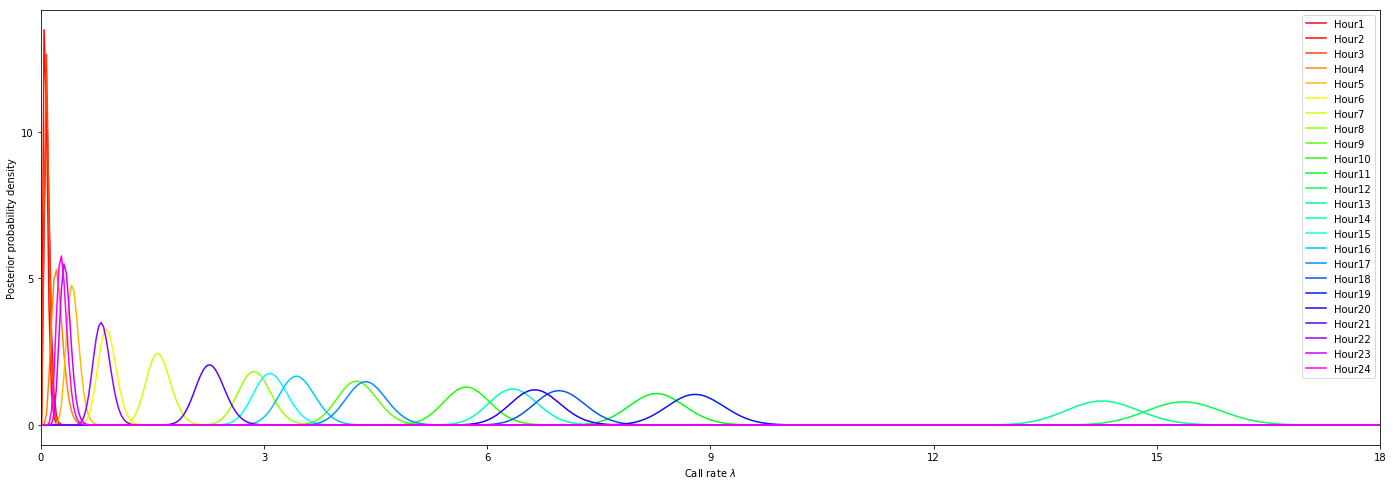

In [0]:
fig = plt.figure(figsize=(24,8))
cm = plt.get_cmap('gist_rainbow')
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/24) for i in range(24)]) #plot all 24 hours in different colors
for i in range(24):
  ax.plot(lambdas,intervals[i],label="Hour"+str(i+1))
plt.xticks(np.arange(0,20,3))
plt.yticks(np.arange(0,14,5))
plt.xlim(0,18)
plt.xlabel("Call rate $\lambda$")
plt.ylabel("Posterior probability density")
plt.legend(loc="best")

I then try to plot the posterior with three subplots with continuous x-axis, which let us observe the lower end (the distributions around 0.2) easier. Note that for each of the subplot, the x-axis has different scales, so the width of the distribution in each subplot is not directly comparable.

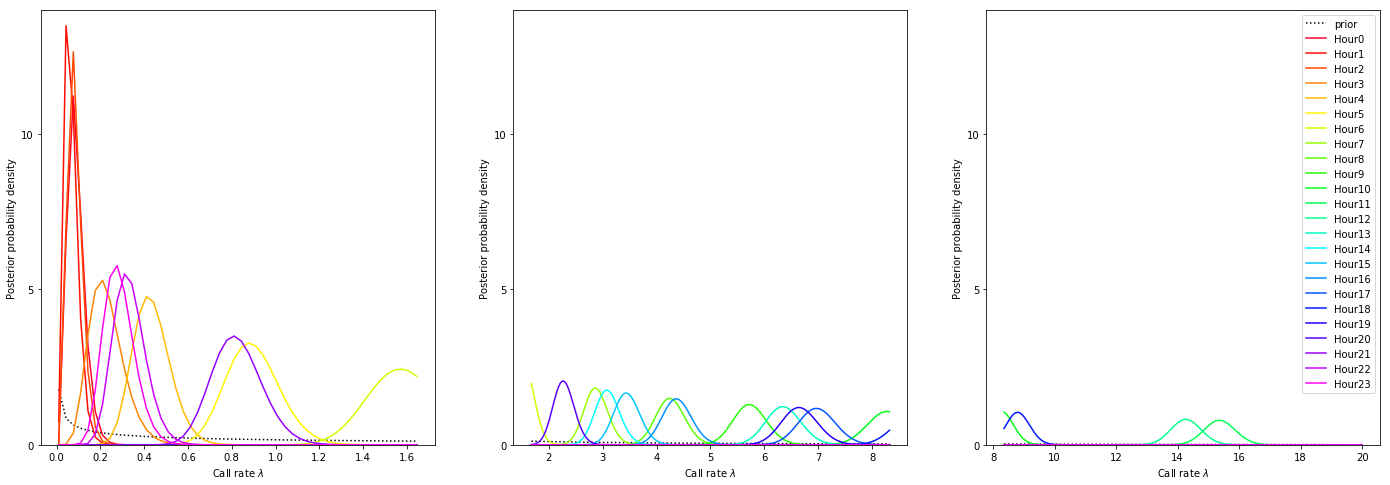

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(24,8))
cm = plt.get_cmap('gist_rainbow')

xrange = [lambdas[0:50],lambdas[50:250],lambdas[250:]] #split the posterior into three ranges
interval_index = 0

#plot three ranges of posterior
for i in range(3): 
  x = xrange[i]
  ax[i].set_prop_cycle(color=[cm(1.*i/24) for i in range(24)])
  ax[i].plot(x, prior(x), color='black', linestyle=':', label='prior')
  for hour in range(len(intervals)):
    ax[i].plot(x, intervals[hour][interval_index:interval_index+len(x)], label="Hour"+str(hour))
  interval_index = interval_index + len(x)
  ax[i].set_ylim([0, 14])
  ax[i].set_yticks(np.arange(0,14,5))
  ax[i].set_xlabel("Call rate $\lambda$")
  ax[i].set_ylabel("Posterior probability density")
plt.legend(loc='best')

Then, we can calculate the 98% percent confidence interval.

In [0]:
def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

#compute the 98% confidence interval for each hour
conf_interv = []
for i in range(len(intervals)):
  conf_interv.append((compute_percentile(lambdas,intervals[i],0.01),compute_percentile(lambdas,intervals[i],0.99)))

for hour in range(24):
    print("The 98% confidence interval for",f'{hour:02}:00-{hour + 1:02}:00',"is",conf_interv[hour])

The 98% confidence interval for 00:00-01:00 is (0.01, 0.17686143572621035)
The 98% confidence interval for 01:00-02:00 is (0.01, 0.14348914858096828)
The 98% confidence interval for 02:00-03:00 is (0.01, 0.17686143572621035)
The 98% confidence interval for 03:00-04:00 is (0.07674457429048413, 0.44383973288814693)
The 98% confidence interval for 04:00-05:00 is (0.2436060100166945, 0.6440734557595993)
The 98% confidence interval for 05:00-06:00 is (0.6107011686143573, 1.1780300500834724)
The 98% confidence interval for 06:00-07:00 is (1.2114023372287146, 1.978964941569282)
The 98% confidence interval for 07:00-08:00 is (2.3794323873121868, 3.3806010016694485)
The 98% confidence interval for 08:00-09:00 is (3.6475792988313853, 4.882353923205342)
The 98% confidence interval for 09:00-10:00 is (5.0158430717863105, 6.450851419031719)
The 98% confidence interval for 10:00-11:00 is (7.418647746243739, 9.154006677796326)
The 98% confidence interval for 11:00-12:00 is (14.19322203672788, 16.5626

Then I calculate the mean of the number of calls per minute for each hour. The mean is calculated based on its definition: $E[\lambda]=\int _{\Omega}\lambda f(\lambda) d\lambda,$ where $\Omega$ is the support of $\lambda.$ In this case, I can just use the range of $\lambda$ defined above to estimate the mean as the density is 0 when $\lambda$ is above 20.

In [0]:
means = []

#integrate for all 24 hours
for i in range(24):
  means.append(sp.integrate.trapz(np.multiply(intervals[i],lambdas),x=lambdas))

for hour in range(24):  
  print("The mean number of calls per minute at",f'{hour:02}:00-{hour + 1:02}:00',"is", means[hour])

The mean number of calls per minute at 00:00-01:00 is 0.0902596777694541
The mean number of calls per minute at 01:00-02:00 is 0.06893427176881262
The mean number of calls per minute at 02:00-03:00 is 0.08459933352598126
The mean number of calls per minute at 03:00-04:00 is 0.2301032405330592
The mean number of calls per minute at 04:00-05:00 is 0.4352110362949364
The mean number of calls per minute at 05:00-06:00 is 0.8971993962770417
The mean number of calls per minute at 06:00-07:00 is 1.5867527629099136
The mean number of calls per minute at 07:00-08:00 is 2.8798807546781466
The mean number of calls per minute at 08:00-09:00 is 4.259243143371647
The mean number of calls per minute at 09:00-10:00 is 5.734659702305597
The mean number of calls per minute at 10:00-11:00 is 8.291867039536251
The mean number of calls per minute at 11:00-12:00 is 15.372707084664626
The mean number of calls per minute at 12:00-13:00 is 14.277923763925985
The mean number of calls per minute at 13:00-14:00 i

Plot the error-bar plot that shows the confidence interval and mean of the call rate for each hour.

Text(0.5, 1.0, 'Mean and 98% confidence interval over call rate')

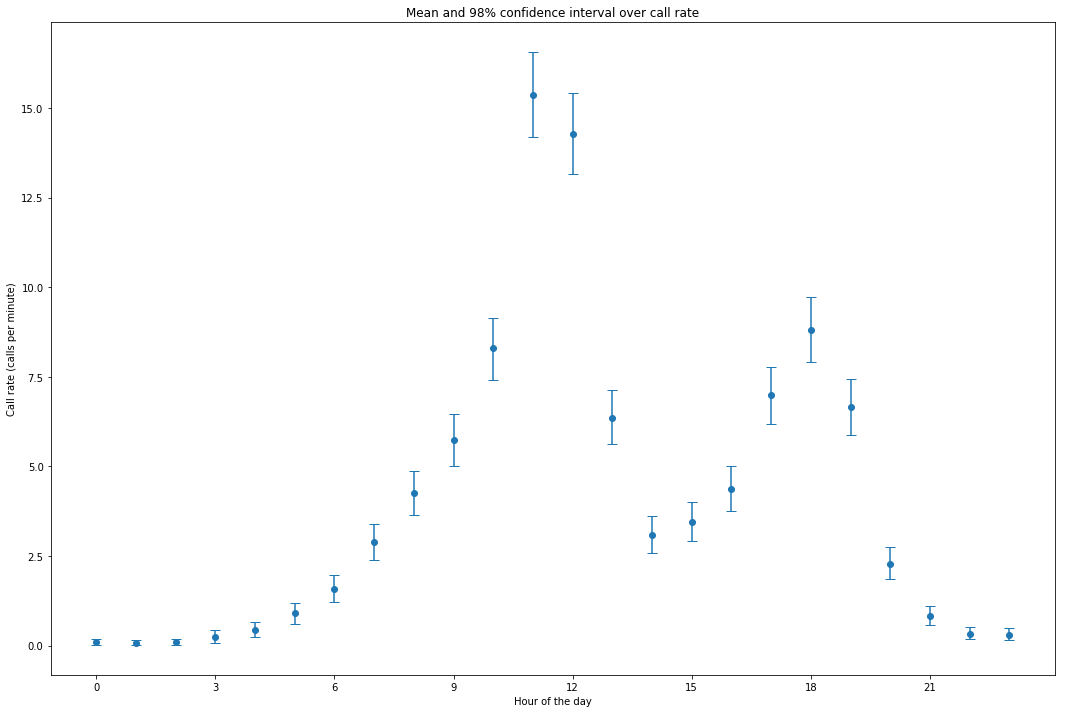

In [0]:
x = [i for i in range(24)]

#the difference in the mean and the 99% (or 1%) percentile estimate is the length of the error bar
plus_minus = np.array(conf_interv).T.reshape(2,24)
error_lower = means - plus_minus[0]
error_upper = plus_minus[1] - means
error = [error_lower,error_upper]

plt.figure(figsize=(18,12))
plt.errorbar(x=x,y=means,yerr=error,linestyle='None',marker='o',capsize=5)
plt.xlabel("Hour of the day")
plt.ylabel("Call rate (calls per minute)")
plt.xticks(np.arange(0,24,3))
plt.title("Mean and 98% confidence interval over call rate")

The above graph shows the estimated average calls per minute for each hour of the day. The bar on each point in the graph indicates the most probable range of the call rate. There are two peaks in call rates, one between 11:00 and 13:00 and the other between 18:00 - 19:00. Tthe 11th and 12th hour (11:00-13:00) are the hours with the most frequent phone calls, at around 15 calls per minute during the time, where as from 00:00 to 7:00 and 21:00 to 24:00, the call rate is below 2 calls per minute. Generally, during the low-call-rate hour the estimate has low fluctuation, as indicated by the error bars in the above graph. For example, at 1:00 the call rate is just slightly above 0 and is almost never above 1. But at 11:00, the estimated range of the call rate is larger, which can be from 14 to 16 calls per minute. Based on my findings, the data center should better hire hourly workers to be flexible when dealing with the large difference in call rates during the peak and low hours.

# 2. Stretch Goal



1.   The key of the function lies in line 6, where we add the log likelihood and the log prior together. Because $\log(a)+\log(b)=\log(ab),$ we save the effort to multiply the likelhood and the prior. Instead, we can just add the log likelihood and the log prior and then transform them back using exponential. Then, after we find the product of the likelihood and prior, we just need a normalizing constant to normalize it so that it becomes a probability distribution. We do this using the scipy trapz integration (represented by the variable "area"). Finally, we divide the unnormalized posterior with the area to obtain the posterior distribution. 
2.   In line four, the "likelihood(params,data)" give us an array of likelihoods of the same parameter $\lambda$ value evaluated different data points. We first log-transform them, and then sum them up. This is equivalent to multiplying these likelihoods at individual data points together and then do the log-transformation. We want to multiply these likelihoods evaluated at different data points because their joint probability distribution, which is the final likelihood we look for, is the product of each $P(x_i|\lambda).$ That is: $P(X|\lambda)=\prod_{i=1}^nP(x_i|\lambda).$ We can do this because we assume that all the calls are independently and identically distributed.

1.   Since $\log(a)-\log(b)=\log(a/b),$ when we subtract the maximum of the log posterior, we are actually dividing each posterior with the maximum posterior. We do this because we want each posterior evaluated at a different parameter value to be on the scale of 0 to 1. This is not the same as normalization the posterior, as is explained below
2.   The scaling in 3 only makes sure that the posteriors are on the scale of 0 to 1. However, they do not make sure that the posterior would integrate to 1. Dividing them by the area under the curve ensures that when we integrate the posterior distribution, we would get 1, so that we have successfully computed a probability distribtuion.



